### Problem Statement

This is a __"challenge"__ question. Attempt only after you have completed all the questions. 
In this exercise, you need to implement the learning of CNN-RNN encoder decoder architecture.
Boilerplate, code for preprocessing data is provided to you. 
You are free to make any changes and modifications as you like. 

__Do not change: model ResNet-18 and batch_size=64__

NOTE:
1. Training on a large dataset requires considerable amount of time. You might also need to tune parameters, pre-processing steps and repeat experiments with different parameters.

2. If you are unable to complete, you might want to complete this work when you reach your home institute. You can save your work on your laptop "File > Download as" 

Once you have completed, try to answer the following questions:
1. What is the perplexity value at the end of the training ?
2. What measures can you use to evaluate the quality of the captions generated ?
3. Can you find example test images where this model's output differs from the pretrained ones.

### 1) Imports

In [1]:
from __future__ import print_function           # Use print() instead of print
from __future__ import division                 # 1 / 2 = 0.5, 1 // 2 = 0
import numpy as np                              # for numpy
import torch                                    # import PyTorch module 
import torch.nn as nn                           # neural network module
from torch.nn.utils.rnn import pack_padded_sequence  # rnn utility function
from torch.utils.data import DataLoader         # dataloader abstracts sampling of minibatch
import torchvision.datasets as dset             # standard machine learning datasets
import torchvision.transforms as tform          # transforms for data augmentation
import torchvision.models as models             # pretrained models
from torch.autograd import Variable             # auto differentiation
import sd_utils as utils                        # some python helper functions ( see: sd_utils.py )
import skimage                                  # for image processing. Note: image is simple a numpy array !!
import skimage.io as skio                       # for image read, write, show operations
from pprint import pprint                       # for pretty printing
from sklearn.preprocessing import LabelEncoder  
from collections import Counter
import nltk                                     # for NLP functions
from itertools import chain
from tqdm import tqdm                           # progress bar
import time
import os
%matplotlib inline

### 2) Hyper Parmaters and Initializations

In [2]:
crop_size = 224                                  # standard crop size used by many pretrained networks
mean_rgb = (0.485, 0.456, 0.406)                 # precomputed mean value ( assume given : its easy to compute, but lets not focus on it)
std_rgb = (0.229, 0.224, 0.225)                  # precomputed std dev value
batch_size = 64
num_workers = 4
img_dir = '../../data/lab5/coco/resized2014/'
annotations_file = '../../data/lab5/coco/annotations/captions_train2014.json'
threshold = 4
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
num_captions = 5
max_length = 50
log_step = 10
save_step = 1000


### 3) Download and Preprocess Dataset

In [3]:
# utils.mkdir_p('../data')
# utils.mkdir_p('../data/lab5')
# utils.mkdir_p('../data/lab5/coco')
# utils.mkdir_p('../data/lab5/coco/resized2014')

transform = tform.Compose([ 
        tform.RandomCrop(crop_size),
        tform.RandomHorizontalFlip(), 
        tform.ToTensor(), 
        tform.Normalize(mean_rgb, std_rgb)])

dset_train = dset.CocoCaptions(root=img_dir,
                               annFile=annotations_file,
                               transform=transform
                              )

loading annotations into memory...
Done (t=1.33s)
creating index...
index created!



Lets have a look at what kind of data we have. Pick one arbitrary image and visualize it along with its captions. For the image to display, we need to undo to normalization

Number of samples:  82783
Image Size:  torch.Size([3, 224, 224])
Image:


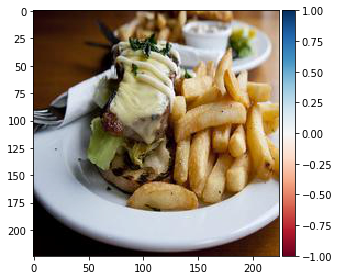

Captions:
[u'A plate topped with an open face sandwich and french fries.',
 u'A plate of fries with some other food on a plate',
 u'A plate holds an open sandwich and french fries.',
 u'A close view of a plate of food which includes fries',
 u'an image of a plate of food on a table']


In [4]:
print('Number of samples: ', len(dset_train))
img, target = dset_train[45] # load some sample
print("Image Size: ", img.size())
print("Image:")
cimg = img.clone().numpy()
nimg = cimg * np.array(std_rgb).reshape(3,1,1) + np.array(mean_rgb).reshape(3,1,1)
nimg = nimg.transpose([1,2,0])
skio.imshow(nimg)
skio.show()
print("Captions:")
pprint(target)

### 4) Create DataLoader objects

In [5]:
dloader_train = torch.utils.data.DataLoader(dataset=dset_train, 
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=num_workers,
                                           )

In [6]:
#itr = iter(dloader_train)
# print(next(itr))

In [7]:

# threshold = 1000

dloader_train_seq = torch.utils.data.DataLoader(dataset=dset_train, 
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=num_workers,
                                            )

# print(dloader_train_seq)
# itr = iter(dloader_train_seq)
# print(itr)
# a = next(itr)

ctr = Counter()
for i, (_, lbl) in enumerate(tqdm(dloader_train_seq)):
    lbl_list = list(chain(*lbl))
    # print(lbl_list)
    for x in lbl_list:
        tokens = nltk.tokenize.word_tokenize(x.lower())
        # print(tokens)
        ctr.update(tokens)
          
# words = [word for word, cnt in ctr.items() if cnt >= threshold]
words = [word for word, cnt in ctr.items()]
# print(sorted(words))

100%|██████████| 1294/1294 [01:02<00:00, 20.83it/s]


In [8]:
words = ['<pad>', '<start>', '<end>', '<unk>'] + words   # add additional tokens
vocab_len = len(words)
print(vocab_len)

25127


In [9]:
le = LabelEncoder()
le.fit(words)
le.transform(['river', 'hanging', 'oranges'])

array([18095, 10137, 14953])

### 5) Define Network

In [10]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-18 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()
        
    def init_weights(self):
        """Initialize the weights."""
        self.linear.weight.data.normal_(0.0, 0.02)
        self.linear.bias.data.fill_(0)
        
    def forward(self, images):
        """Extract the image feature vectors."""
        features = self.resnet(images)
        features = Variable(features.data)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        """Initialize weights."""
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Samples captions for given image features (Greedy search)."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(20):                                      # maximum sampling length
            hiddens, states = self.lstm(inputs, states)          # (batch_size, 1, hidden_size), 
            outputs = self.linear(hiddens.squeeze(1))            # (batch_size, vocab_size)
            predicted = outputs.max(1)[1]
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
        sampled_ids = torch.cat(sampled_ids, 1)                  # (batch_size, 20)
        return sampled_ids.squeeze()
    
 # Build the models
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, 
                     vocab_len, num_layers)
encoder.cuda()
decoder.cuda()

DecoderRNN (
  (embed): Embedding(25127, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear (512 -> 25127)
)

### 6) Define Loss function and Optimizer

In [11]:
 # Loss and Optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

### 7) Training Loop

In [12]:


# Train the Models
num_captions = 5
max_length = 60
log_step = 10
save_step = 1000
model_path = '.'

total_step = len(dloader_train)
for epoch in tqdm(range(num_epochs)):
   
    for i, (images, captions) in enumerate(dloader_train):
        
        time_s_step = time.time()
        clk_s_step = time.clock()
        
        # Set mini-batch dataset
        # print(len(captions))
        # pprint([len(x) for x in captions])
        
        if images.size(0) != batch_size:
            print('skip last batch')
            continue
        
        captions_ = map(list, captions)      # convert list of tuples to list of list
        captions_mb = torch.zeros(batch_size, max_length).long()
        cap_mb = []
        lengths = []
        #lengths.append(batch_size)
        for j in range(batch_size):
            r = np.random.randint(num_captions)
            cap_ = captions_[r][j]
            cap_l = nltk.tokenize.word_tokenize(cap_.lower())
            cap_l = ['<start>'] + cap_l + ['<end>']
            cap = le.transform(cap_l)
            # pprint(cap)
            len_cap = len(cap)
            lengths.append(len_cap)
            # print(captions_mb[j, max_length-len_cap:].size())
            # print(torch.LongTensor(cap).size())
            # captions_mb[j, max_length-len_cap:] = torch.LongTensor(cap)
            captions_mb[j, max_length-len_cap:] = torch.LongTensor(cap)
        
        idx = np.array(lengths).argsort()[::-1].tolist()
        sz = images.size()
        images_mb = torch.zeros(sz).float()
        images_mb.index_copy_(0, torch.LongTensor(idx), images)
        images_mb = Variable(images_mb.cuda(), volatile=True)
        # print(images_mb.size())
        lengths_mb = [lengths[x] for x in idx]
        captions_mb = Variable(captions_mb.cuda())
        
        targets = pack_padded_sequence(captions_mb, lengths_mb, batch_first=True)[0]
        targets = targets.cuda()

        # Forward, Backward and Optimize
        
        # TODO: YOUR CODE HERE

        time_e_step = time.time()
        clk_e_step = time.clock()
        
        # Print log info
        if i % log_step == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f | Time: [%05.2f, %05.2f] sec'
                  %(epoch, num_epochs, i, total_step, 
                    loss.data[0], np.exp(loss.data[0]), time_e_step-time_s_step, clk_e_step-clk_s_step)) 
            
        # Save the models
        if (i+1) % save_step == 0:
            torch.save(decoder.state_dict(), 
                       os.path.join(model_path, 
                                    'decoder-%d-%d.pkl' %(epoch+1, i+1)))
            torch.save(encoder.state_dict(), 
                       os.path.join(model_path, 
                                    'encoder-%d-%d.pkl' %(epoch+1, i+1)))
    

  0%|          | 0/5 [00:00<?, ?it/s]


NameError: name 'loss' is not defined

### 8) Testing Loop

In [ ]:
# YOUR CODE HERE